# ARCH-GARCH Volatility Modeling: U.S. Dollar Index 

In this brief project, I will be examining the volatility of the U.S. Dollar Index which can be a possible 
indicator to other instruments such as the equity market indices. This will not be an exhaustive view but a more 
generalized view of volatility that is not commonly examined. 

Volatility, as we all know, is a statistical measure of the dispersion of returns or the numeric uncertainty for 
a given security, portfolio, or market indices. In most cases, the higher the volatility, the riskier the security. 
Volatility is often measured as either the standard deviation or variance between returns from that same security or 
market index.

The volatility models I will employ are the following:
 * the autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that 
   describes the variance of the current error term 
 * and the generalized autoregressive conditional heteroskedasticity (GARCH) model, if an autoregressive moving 
   average (ARMA) model is assumed for the error variance.

The trade-weighted US dollar index, also known as the broad index, is a measure of the value of the United States 
dollar relative to other world currencies. It is a trade weighted index that improves on the older U.S. Dollar Index 
by using more currencies and the updating the weights yearly (rather than never). The base index value is 100 in 
Jan 1997. This is referenced in: https://en.wikipedia.org/wiki/Trade-weighted_US_dollar_index

## Import Libraries

In [1]:
%matplotlib inline

#system library
import os
import sys
import warnings
from datetime import date

#data manipulation 
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

#statistics modeling
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

#evaluation metrics
from sklearn.metrics import mean_squared_error

#time series modeling
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

#data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
#warnings suppression
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Import Data

In [3]:
#web scrape data
dollar = web.DataReader('DTWEXBGS', 'fred', '2015', '2020-10-30').squeeze()
dollar_returns = np.log(dollar).diff().dropna().mul(100) # rescale to faciliate optimization

In [4]:
dollar.head()

DATE
2015-01-01         NaN
2015-01-02    102.9024
2015-01-05    103.4973
2015-01-06    103.2934
2015-01-07    103.6312
Name: DTWEXBGS, dtype: float64

In [5]:
dollar_returns.head()

DATE
2015-01-05    0.576456
2015-01-06   -0.197204
2015-01-07    0.326496
2015-01-08   -0.339954
2015-01-09   -0.153682
Name: DTWEXBGS, dtype: float64

## Exploratory Data Analysis (EDA): Returns and Volatility

In [6]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

#### Observations on Autocorrelation, PACF, and ACF:

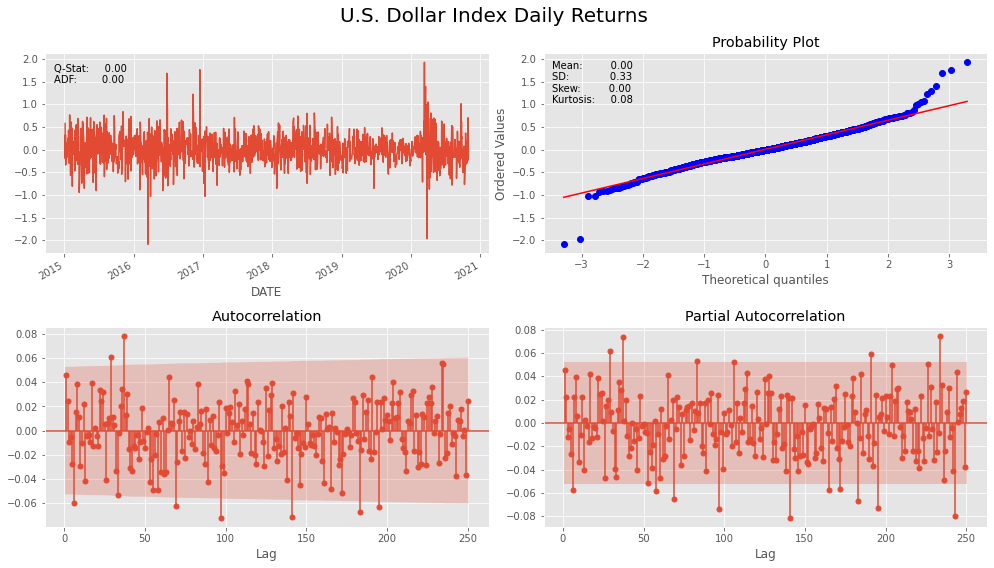

In [7]:
plot_correlogram(dollar_returns, lags=250, title='U.S. Dollar Index Daily Returns')

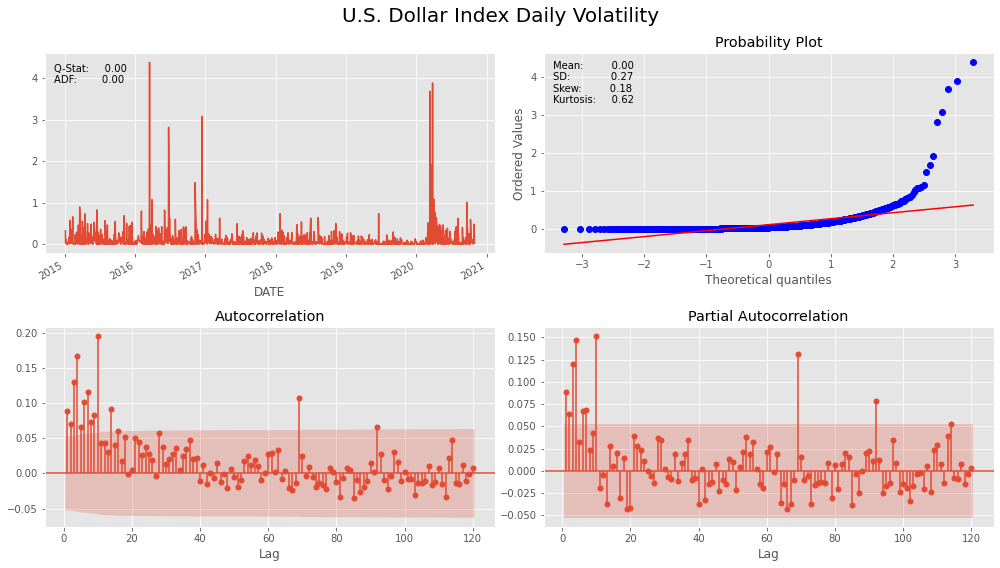

In [8]:
plot_correlogram(dollar_returns.sub(dollar_returns.mean()).pow(2), lags=120, title='U.S. Dollar Index Daily Volatility')

## Modeling

We can use an estimate on the GARCH model to capture the linear relationship of past volatilities. Subsequently, 
use the rolling 5-year windows to estimate a GARCH(p, q) model with p and q ranging from 1-4 to generate 1-step 
out-of-sample estimation.

Comparing the RMSE of the predicted volatility relative to the actual squared deviation of the return from its 
mean will help to identify the most predictive model. We are using winsorized *** data to limit the impact of 
extreme return values reflected in the very high positive skew of the volatility.

*** The winsorized mean is a useful estimator because it is less sensitive to outliers than the mean but will still 
give a reasonable estimate of central tendency or mean for almost all statistical models. In this regard it is 
referred to as a robust estimator. Reference: https://en.wikipedia.org/wiki/Winsorized_mean

In [9]:
trainsize = 5 * 252 # 5 years training set
data = dollar_returns.clip(lower=dollar_returns.quantile(.05),
                           upper=dollar_returns.quantile(.95))
T = len(dollar_returns)
test_results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        test_results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


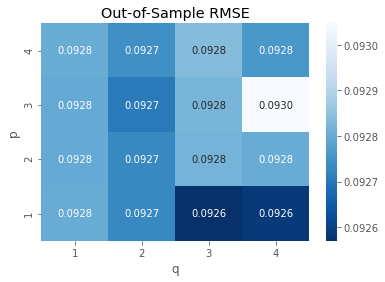

In [10]:
s = pd.Series(test_results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)
sns.heatmap(s, cmap='Blues_r', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

From the Out-of-Sample RMSE, GARCH(2, 2) model achieved the second-lowest RMSE but has fewer parameters than the slightly better-performing GARCH(1, 3).

By Comparison, the output shows:

 * the maximum log-likelihood as well as the 
 * AIC and 
 * BIC criteria 

that are commonly minimized when selecting models based on in-sample performance. 

Shown below is the result for:

 * the Constant Mean Model, which uses a constant estimate, as well as 
 * the GARCH Volatility Model parameters for the constant omega, 
 * the AR parameters, α, and 
 * the MA parameters, β, 

all of which appears to be statistically significant:

#### Estimate of the GARCH(1,3) Model

In [11]:
best_p, best_q = 1, 3

In [12]:
am = ConstantMean(dollar_returns.clip(lower=dollar_returns.quantile(.05),
                                      upper=dollar_returns.quantile(.95)))
am.volatility = GARCH(1, 0, 3)
am.distribution = Normal()
model = am.fit(update_freq=5)
print(model.summary())

Iteration:      5,   Func. Count:     46,   Neg. LLF: 180.1266118949208
Iteration:     10,   Func. Count:     87,   Neg. LLF: 122.38640297068943
Iteration:     15,   Func. Count:    122,   Neg. LLF: 122.37961222158256
Optimization terminated successfully    (Exit mode 0)
            Current function value: 122.37961222183714
            Iterations: 15
            Function evaluations: 122
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               DTWEXBGS   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -122.380
Distribution:                  Normal   AIC:                           256.759
Method:            Maximum Likelihood   BIC:                           288.173
                                        No. Observations:                 1388
Date:             

#### Residuals of GARCH(1,3) Model

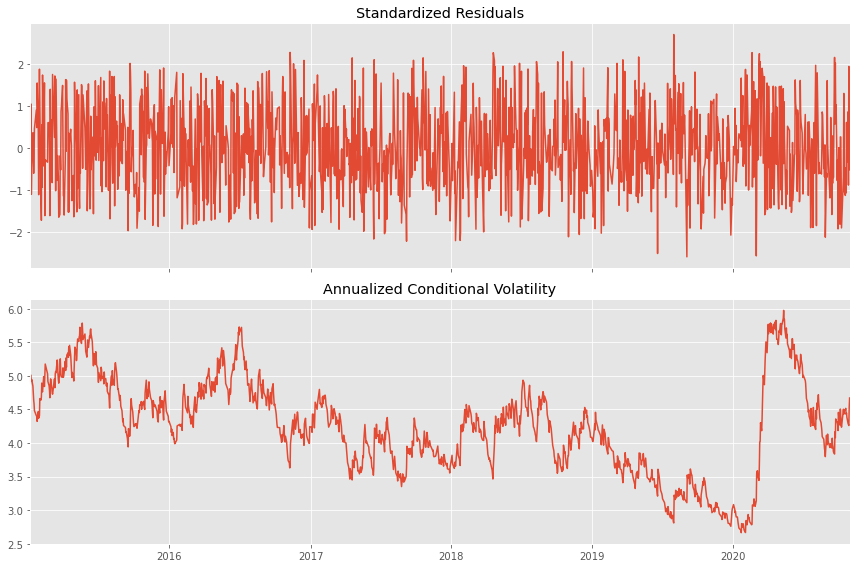

In [13]:
fig = model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout()

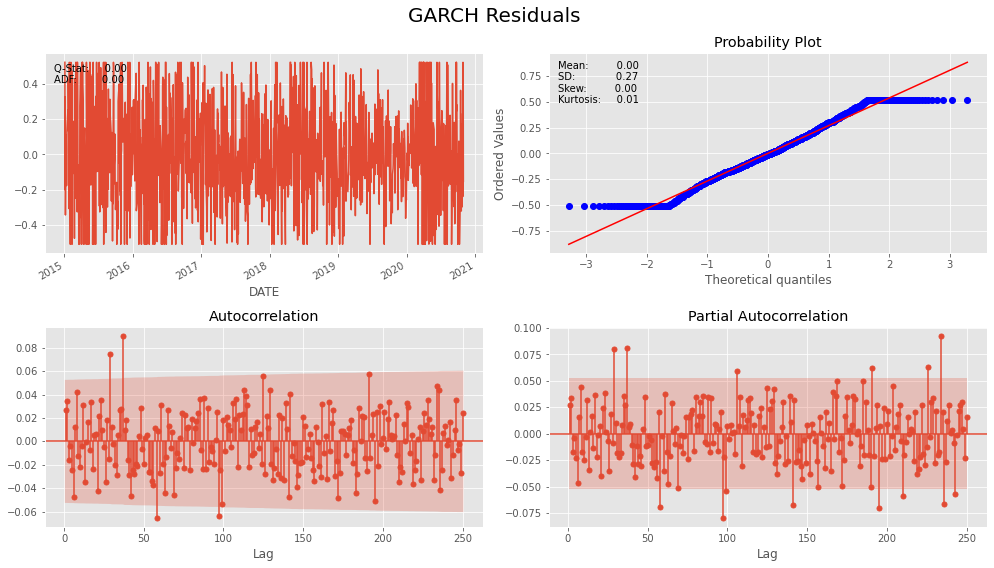

In [14]:
plot_correlogram(model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')

In [15]:
# reset the p,q variables
del best_p
del best_q

#### Estimate of GARCH(2,2) Model

In [16]:
best_p, best_q = 2, 2

In [17]:
am = ConstantMean(dollar_returns.clip(lower=dollar_returns.quantile(.05),
                                      upper=dollar_returns.quantile(.95)))
am.volatility = GARCH(2, 0, 2)
am.distribution = Normal()
model = am.fit(update_freq=5)
print(model.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 126.57153210535596
Iteration:     10,   Func. Count:     87,   Neg. LLF: 124.24090206423742
Iteration:     15,   Func. Count:    122,   Neg. LLF: 122.35003445015866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 122.3500344499325
            Iterations: 15
            Function evaluations: 122
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               DTWEXBGS   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -122.350
Distribution:                  Normal   AIC:                           256.700
Method:            Maximum Likelihood   BIC:                           288.114
                                        No. Observations:                 1388
Date:             

#### Residuals of GARCH(2,2) Model

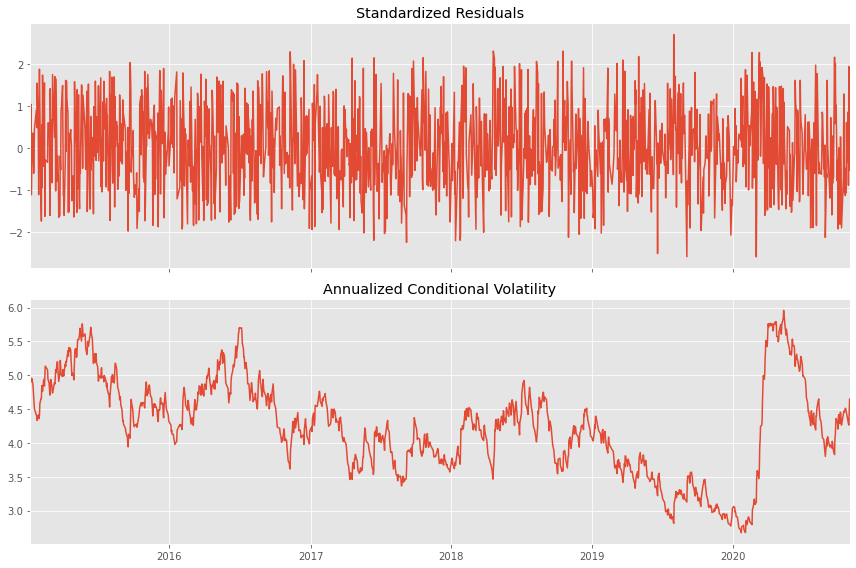

In [18]:
fig = model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout()

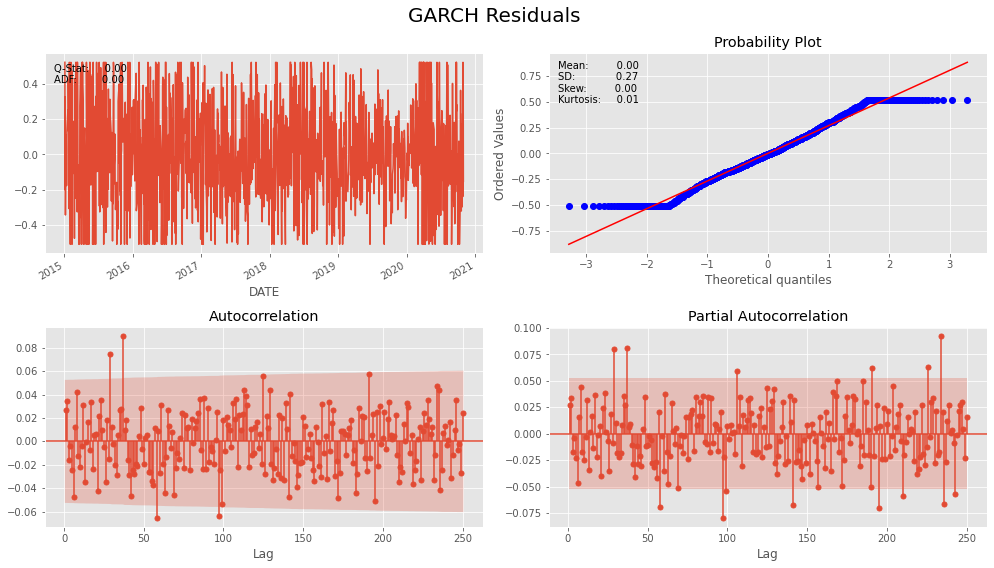

In [19]:
plot_correlogram(model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')

References: ML for trading - stefan jansen; wikipedia